In [60]:
import pvlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

We will use `infinite_sheds.get_irradiance` to give us shaded fraction for the whole array/row, then manually calculate shaded fraction for each course going up the row. For example, in a 3P crystalline array (`eff_row_side_num_mods = 3`), with an array shaded fraction of 0.5, the shaded fraction in each course, starting from the bottom, would be: 1.0, 0.5, 0.0.

In [61]:
fs_array = 0.5
eff_row_side_num_mods = 3

fs = {}
for n in range(0,eff_row_side_num_mods):
    fs_course_min = n/eff_row_side_num_mods
    fs_course_max = (n+1)/eff_row_side_num_mods
    fs[n] = np.minimum(1,np.maximum(0,(fs_array-fs_course_min)/(fs_course_max-fs_course_min)))
    print(fs[n])

1.0
0.5000000000000001
0.0


Here's the same thing, but iterating through a range of array shaded fractions (`fs_array`) and plotting the output to confirm it makes sense. Feel free to change the effective number of modules on the side of the row (`eff_row_side_num_mods`).

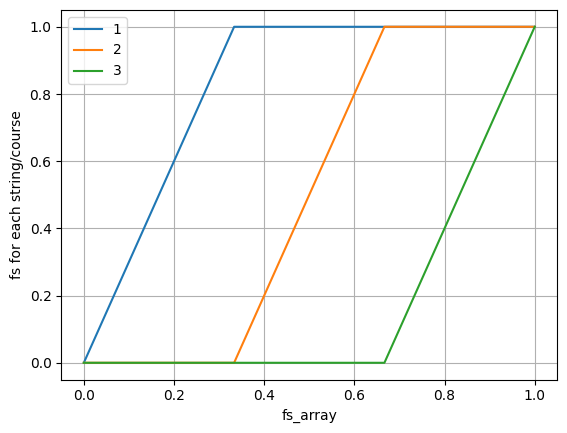

In [62]:
eff_row_side_num_mods = 3 # <-- change this to try other numbers of courses/strings per row
output = []
for fs_array in np.linspace(0,1,100):
    fs = {}
    for n in range(0,eff_row_side_num_mods):
        fs_course_min = n/eff_row_side_num_mods
        fs_course_max = (n+1)/eff_row_side_num_mods
        fs[n] = np.minimum(1,np.maximum(0,(fs_array-fs_course_min)/(fs_course_max-fs_course_min)))

    output.append([fs_array] + list(fs.values()))
df = pd.DataFrame(output).rename(columns={0: 'fs_array'}).set_index('fs_array')
df.plot()
plt.ylabel('fs for each string/course')
plt.grid()
plt.show()

In [70]:
def plant_power_with_shade_losses(
    resource_data,
    latitude,
    longitude,
    mount_type,
    gcr,
    dc_capacity_plant,
    power_plant_ac_max,
    dc_loss_fraction,
    gamma_pdc,
    shade_loss_model,
    default_site_transposition_model='haydavies',
    backtrack=pd.NA,
    max_tracker_angle=pd.NA,
    axis_tilt=pd.NA,
    axis_azimuth=pd.NA,
    fixed_tilt=pd.NA,
    fixed_azimuth=pd.NA,
    n_cells_up=12,
    row_side_num_mods=pd.NA,
    row_height_center=pd.NA,
    row_pitch=pd.NA,
    **kwargs,
    ):

    # Fill in some necessary variales with defaults if there is no value provided
    if pd.isna(row_side_num_mods):
        row_side_num_mods = 1 # default if no value provided

    if pd.isna(row_height_center):
        row_height_center = 1 # default if no value provided

    if pd.isna(row_pitch):
        row_pitch = 2 / gcr # default if no value provided
    
    transposition_model = default_site_transposition_model
    # transposition_model = 'perez-driesse'
    # transposition_model = 'haydavies'
    # transposition_model = 'isotropic'

    eta_inv_nom = 0.98

    times = resource_data.index 
    loc = pvlib.location.Location(latitude=latitude, longitude=longitude, tz=times.tz)
    solar_position = loc.get_solarposition(times)

    # surface tilt and azimuth
    if mount_type == 'single-axis':  
        # tracker orientation angles
        singleaxis_kwargs = dict(apparent_zenith=solar_position.apparent_zenith,
                                apparent_azimuth=solar_position.azimuth,
                                axis_tilt=axis_tilt,
                                axis_azimuth=axis_azimuth,
                                backtrack=backtrack,
                                gcr=gcr,
                                )
        orientation = pvlib.tracking.singleaxis(max_angle=max_tracker_angle,
                                                **singleaxis_kwargs)
        surface_tilt = orientation.surface_tilt.fillna(0)
        surface_azimuth = orientation.surface_azimuth.fillna(0)
    elif mount_type == 'fixed':
        surface_tilt = float(fixed_tilt)
        surface_azimuth = float(fixed_azimuth)

    # dni and airmass
    dni_extra = pvlib.irradiance.get_extra_radiation(resource_data.index)
    # airmass = pvlib.atmosphere.get_relative_airmass(
    #     solar_position.apparent_zenith,
    #     model='kastenyoung1989'
    # )

    # empty dictionaries to be filled in while looping through the number of modules on the side of each row
    irrad_inf_sh = {} # tilted irradiance 
    fd = {} # diffuse fraction
    fs = {} # shaded fraction
    poa_front = {}
    pnorm = {}
    shade_loss = {}
    pdc = {}
    t_cell = {}
    pdc_shaded = {}
    pdc_inv = {}

    irrad_inf_sh = pvlib.bifacial.infinite_sheds.get_irradiance(
        surface_tilt = surface_tilt, 
        surface_azimuth = surface_azimuth,
        solar_zenith = solar_position.apparent_zenith, 
        solar_azimuth = solar_position.azimuth,
        gcr = gcr, 
        height = row_height_center,
        pitch = row_pitch,
        ghi = resource_data.ghi,
        dhi = resource_data.dhi,
        dni = resource_data.dni,
        albedo = resource_data.albedo,
        model = transposition_model,
        dni_extra = dni_extra,
        # TODO: add bifaciliaty later if needed...
    )

    # set the "effective" number of modules on the side of each row
    if shade_loss_model == 'non-linear_simple':
        eff_row_side_num_mods = int(row_side_num_mods)
    elif shade_loss_model == 'non-linear_simple_twin_module':
        # twin modules are treated as effectively two modules with half as many cells each
        eff_row_side_num_mods = int(row_side_num_mods) * 2
        n_cells_up = n_cells_up / 2
    # for linear shade loss, it really doesn't matter how many modules there are on the side of each row, so just run everything once to save time
    elif shade_loss_model == 'linear':
        eff_row_side_num_mods = 1 

    fs_array = irrad_inf_sh['shaded_fraction_front']

    # work backwards to unshaded direct irradiance for the whole array:
    poa_front_direct_unshaded = irrad_inf_sh['poa_front_direct'] / (1-fs_array)

    for n in range(0,eff_row_side_num_mods):

        # shaded fraction for each string (course) going up the row
        fs_course_min = n/eff_row_side_num_mods
        fs_course_max = (n+1)/eff_row_side_num_mods
        fs[n] = np.minimum(1,np.maximum(0,(fs_array-fs_course_min)/(fs_course_max-fs_course_min)))

        # front POA and diffuse fraction for each course
        poa_front[n] = ((1-fs[n]) * poa_front_direct_unshaded) + irrad_inf_sh['poa_front_diffuse']
        # fd[n] = irrad_inf_sh['poa_front_diffuse'] / poa_front[n]
        fd[n] = irrad_inf_sh['poa_front_diffuse'] / (irrad_inf_sh['poa_front_diffuse'] + poa_front_direct_unshaded)

        if shade_loss_model == 'linear':
            shade_loss[n] = fs[n] * (1 - fd[n])
            # shade_loss[n] = 0 # linear shade loss should already be included in infinite_sheds.get_irradiance
        else: # 'non-linear' or 'non-linear_twin_module'
            pnorm[n] = np.where(fs[n] < 1/n_cells_up, 1 - (1 - fd[n])*fs[n]*n_cells_up, fd[n])
            shade_loss[n] = 1 - pnorm[n]

        # steady state cell temperature - faiman is much faster than fuentes, simpler than sapm
        t_cell[n] = pvlib.temperature.faiman(poa_front[n],
                                        resource_data.temp_air,
                                        resource_data.wind_speed,
        )

        # transient cell temperature, since we are working with intervals shorter than 20 minutes
        t_cell[n] = pvlib.temperature.prilliman(t_cell[n], resource_data.wind_speed)

        # PVWatts dc power
        # pdc[n] = pvlib.pvsystem.pvwatts_dc(poa_front[n],
        #                                 t_cell[n],
        #                                 dc_capacity_plant,
        #                                 gamma_pdc)
        pdc[n] = pvlib.pvsystem.pvwatts_dc((irrad_inf_sh['poa_front_diffuse'] + poa_front_direct_unshaded),
                                        t_cell[n],
                                        dc_capacity_plant,
                                        gamma_pdc)
        pdc_shaded[n] = pdc[n] * (1 - shade_loss[n]) # apply shade losses
        pdc_inv[n] = pdc_shaded[n] * (1 - dc_loss_fraction) # dc power into the inverter after losses
        
    # inverter dc input is ac nameplate divided by nominal inverter efficiency
    pdc0 = power_plant_ac_max/eta_inv_nom 

    # average the dc power across n positions up the row
    pdc_inv_total = pd.concat(pdc_inv, axis=1, sort=False).mean(axis=1)

    # ac power with PVWatts inverter model
    power_ac = pvlib.inverter.pvwatts(pdc_inv_total, pdc0, eta_inv_nom)

    return power_ac, pnorm, fs, poa_front, irrad_inf_sh['poa_front']

Load plant/inverter specs. I have data from 5 anonymous plants and 2 Solar Data Bounty Prize sites. 

For 2 of the anonymous plants, I've pulled data from more than one inverter so that we can look at variation within a plant (since row spacing, tilt, etc., may not be perfectly uniform). "unit_id" values of 30 and 31 are for one of those plants, and 40 and 41 are for the other.

In [76]:
filename = 'plant_specs_pvpmc_rev2.csv'
header = 4 # row (0-index, so starting count at 0) of the header
index_col = 'None'
plants_df = pd.read_csv(filename, header=header).set_index('unit_id') # read in as a Pandas DataFrame
num_plants = len(plants_df.index) # number of plants
plants_df

,Variable:,unit_name,other_name,owner_name,offtaker_name,asset_type,cod,latitude,longitude,altitude,...,strings_per_inverter,num_inverters,module_model,inverter_model,shade_loss_model,n_cells_up,module_length,module_width,module_spec_url,default_site_transposition_model
unit_id,,,,,,,,,,,,,,,,,,,,,
30,NaN,Fixed 2P 72 cell SW - inv1,NaN,NaN,NaN,inverter,NaN,31.5000,-84.0000,50,...,NaN,NaN,NaN,NaN,non-linear_simple,12,NaN,NaN,NaN,haydavies
31,NaN,Fixed 2P 72 cell SW - inv2,NaN,NaN,NaN,inverter,NaN,31.5000,-84.0000,50,...,NaN,NaN,NaN,NaN,non-linear_simple,12,NaN,NaN,NaN,haydavies
10,NaN,Fixed thin film,NaN,NaN,NaN,inverter,NaN,32.5000,-84.5000,200,...,NaN,NaN,NaN,NaN,linear,1,NaN,NaN,NaN,haydavies
20,NaN,Tracking thin film,NaN,NaN,NaN,inverter,NaN,32.5000,-84.5000,200,...,NaN,NaN,NaN,NaN,linear,1,NaN,NaN,NaN,haydavies
40,NaN,Fixed 2P twin - inv1,NaN,NaN,NaN,inverter,NaN,32.5000,-83.5000,100,...,NaN,NaN,NaN,NaN,non-linear_simple_twin_module,26,NaN,NaN,NaN,haydavies
41,NaN,Fixed 2P twin - inv2,NaN,NaN,NaN,inverter,NaN,32.5000,-83.5000,100,...,NaN,NaN,NaN,NaN,non-linear_simple_twin_module,26,NaN,NaN,NaN,haydavies
50,NaN,Fixed 2P 72 cell,NaN,NaN,NaN,inverter,NaN,31.0000,-81.5000,20,...,NaN,NaN,NaN,NaN,non-linear_simple,12,NaN,NaN,NaN,haydavies
9069,NaN,Simon Solar,Simon,NaN,NaN,plant,NaN,33.6762,-83.6760,330,...,NaN,39.0,NaN,NaN,non-linear_simple,12,NaN,NaN,NaN,haydavies
9068,NaN,SR_CO,SR Kersey,NaN,NaN,plant,NaN,40.3864,-104.5512,1407,...,NaN,2.0,NaN,NaN,linear,1,NaN,NaN,NaN,haydavies


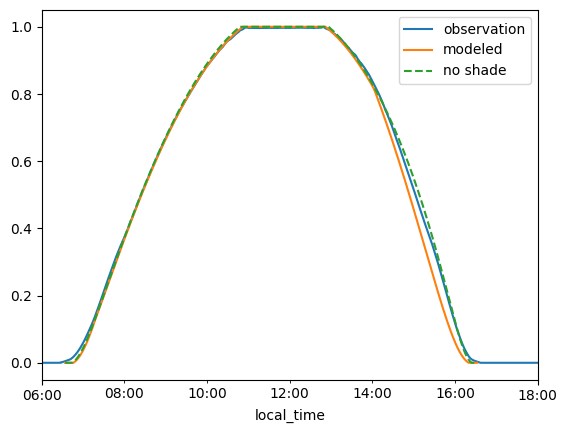

In [77]:
# pick plant/inv unit number:
unit_id = 10

# read in normalized observed power from a reference plant
power_obs = pd.read_csv('sample_data/plant_' + str(unit_id) + '.csv',
                        index_col=0,
                        parse_dates = ["local_time"])

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 
# make some clear sky resource data. Can replace with NSRDB data later
times = pd.date_range('2021-12-14 6:00', '2021-12-14 18:00', freq='1min', tz='Etc/GMT+6')
loc = pvlib.location.Location(latitude=plant_data['latitude'], longitude=plant_data['longitude'], tz=times.tz)
resource_data = loc.get_clearsky(times)
resource_data['temp_air'] = 15 # use 15 deg C as generic value
resource_data['wind_speed'] = 2 # use 2 m/s as generic value
resource_data['albedo'] = 0.2 # use 0.2 as a generic value
plant_data_new = { **plant_data,
                  'dc_loss_fraction':0.08,
                  }
power_ac_modeled, pnorm0, fs0, poa_front, poa_front_inf_sh = plant_power_with_shade_losses(resource_data, **plant_data_new)

# negligible shade w/ linear loss model
plant_data_new = { **plant_data,
                  'dc_loss_fraction':0.08,
                  'gcr':0.00000001,
                  'row_side_num_mods':1,
                  'shade_loss_type':'linear',
                  'cell_type':'thin-film',
                  }
power_ac_no_shade, _, _, _, _ = plant_power_with_shade_losses(resource_data, **plant_data_new)

(power_obs / power_obs.max()).plot()
(power_ac_modeled / power_ac_modeled.max()).plot()
(power_ac_no_shade / power_ac_modeled.max()).plot(linestyle='--')
plt.legend(['observation','modeled','no shade'])
plt.show()

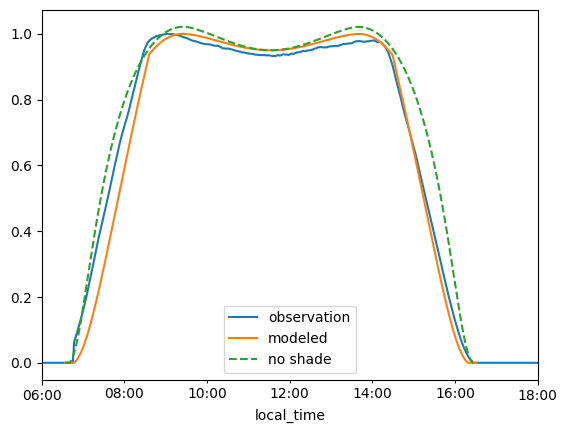

In [78]:
# pick plant/inv unit number:
unit_id = 20

# read in normalized observed power from a reference plant
power_obs = pd.read_csv('sample_data/plant_' + str(unit_id) + '.csv',
                        index_col=0,
                        parse_dates = ["local_time"])

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 
# make some clear sky resource data. Can replace with NSRDB data later
times = pd.date_range('2021-12-14 6:00', '2021-12-14 18:00', freq='1min', tz='Etc/GMT+6')
loc = pvlib.location.Location(latitude=plant_data['latitude'], longitude=plant_data['longitude'], tz=times.tz)
resource_data = loc.get_clearsky(times)
resource_data['temp_air'] = 15 # use 15 deg C as generic value
resource_data['wind_speed'] = 2 # use 2 m/s as generic value
resource_data['albedo'] = 0.2 # use 0.2 as a generic value
plant_data_new = { **plant_data,
                  }
power_ac_modeled, pnorm0, fs0, poa_front, poa_front_inf_sh = plant_power_with_shade_losses(resource_data, **plant_data_new)

# negligible shade w/ linear loss model
plant_data_new = { **plant_data,
                  'gcr':0.00000001,
                  'row_side_num_mods':1,
                  'shade_loss_type':'linear',
                  'cell_type':'thin-film',
                  }
power_ac_no_shade, _, _, _, _ = plant_power_with_shade_losses(resource_data, **plant_data_new)

(power_obs / power_obs.max()).plot()
(power_ac_modeled / power_ac_modeled.max()).plot()
(power_ac_no_shade / power_ac_modeled.max()).plot(linestyle='--')
plt.legend(['observation','modeled','no shade'])
plt.show()

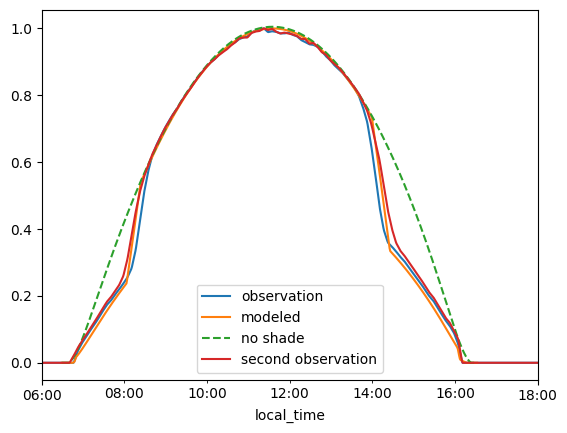

In [67]:
# pick plant/inv unit number:
unit_id = 30
unit_id2 = 31

# read in normalized observed power from a reference plant
power_obs = pd.read_csv('sample_data/plant_' + str(unit_id) + '.csv',
                        index_col=0,
                        parse_dates = ["local_time"])
power_obs2 = pd.read_csv('sample_data/plant_' + str(unit_id2) + '.csv',
                        index_col=0,
                        parse_dates = ["local_time"])

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 
# make some clear sky resource data. Can replace with NSRDB data later
times = pd.date_range('2021-12-14 6:00', '2021-12-14 18:00', freq='1min', tz='Etc/GMT+6')
loc = pvlib.location.Location(latitude=plant_data['latitude'], longitude=plant_data['longitude'], tz=times.tz)
resource_data = loc.get_clearsky(times)
resource_data['temp_air'] = 15 # use 15 deg C as generic value
resource_data['wind_speed'] = 2 # use 2 m/s as generic value
resource_data['albedo'] = 0.2 # use 0.2 as a generic value
plant_data_new = { **plant_data,
                #   'dc_loss_fraction':0.08,
                  }
power_ac_modeled, pnorm0, fs0, poa_front, poa_front_inf_sh = plant_power_with_shade_losses(resource_data, **plant_data_new)

# negligible shade w/ linear loss model
plant_data_new = { **plant_data,
                #   'dc_loss_fraction':0.08,
                  'gcr':0.00000001,
                  'row_side_num_mods':1,
                  'shade_loss_type':'linear',
                  'cell_type':'thin-film',
                  }
power_ac_no_shade, _, _, _, _ = plant_power_with_shade_losses(resource_data, **plant_data_new)

(power_obs / power_obs.max()).plot()
(power_ac_modeled / power_ac_modeled.max()).plot()
(power_ac_no_shade / power_ac_modeled.max()).plot(linestyle='--')
(power_obs2.observed_power / power_obs2.observed_power.max()).plot()
plt.legend(['observation','modeled','no shade', 'second observation'])
plt.show()

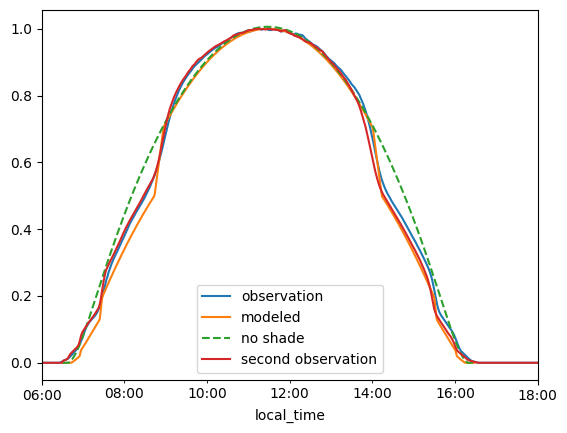

In [68]:
# pick plant/inv unit number:
unit_id = 40
unit_id2 = 41

# read in normalized observed power from a reference plant
power_obs = pd.read_csv('sample_data/plant_' + str(unit_id) + '.csv',
                        index_col=0,
                        parse_dates = ["local_time"])
power_obs2 = pd.read_csv('sample_data/plant_' + str(unit_id2) + '.csv',
                        index_col=0,
                        parse_dates = ["local_time"])

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 
# make some clear sky resource data. Can replace with NSRDB data later
times = pd.date_range('2021-12-14 6:00', '2021-12-14 18:00', freq='1min', tz='Etc/GMT+6')
loc = pvlib.location.Location(latitude=plant_data['latitude'], longitude=plant_data['longitude'], tz=times.tz)
resource_data = loc.get_clearsky(times)
resource_data['temp_air'] = 15 # use 15 deg C as generic value
resource_data['wind_speed'] = 2 # use 2 m/s as generic value
resource_data['albedo'] = 0.2 # use 0.2 as a generic value
plant_data_new = { **plant_data,
                #   'dc_loss_fraction':0.08,
                  'fixed_tilt':20,
                  }
power_ac_modeled, pnorm0, fs0, poa_front, poa_front_inf_sh = plant_power_with_shade_losses(resource_data, **plant_data_new)

# negligible shade w/ linear loss model
plant_data_new = { **plant_data,
                #   'dc_loss_fraction':0.08,
                  'gcr':0.00000001,
                  'row_side_num_mods':1,
                  'shade_loss_type':'linear',
                  'cell_type':'thin-film',
                  }
power_ac_no_shade, _, _, _, _ = plant_power_with_shade_losses(resource_data, **plant_data_new)

(power_obs / power_obs.max()).plot()
(power_ac_modeled / power_ac_modeled.max()).plot()
(power_ac_no_shade / power_ac_modeled.max()).plot(linestyle='--')
(power_obs2.observed_power / power_obs2.observed_power.max()).plot()
plt.legend(['observation','modeled','no shade', 'second observation'])
plt.show()